## Quick and dirty Solution to extension of Newsvendor problem with timeframe as random Variable

The following notebook solves a modified version of the Newsvendor Problem, taking into account "freshness" of the product, a random variable that is distributed over time, with t_0 being the order date.

Assumptions/Simplifications for POC: 
- Demand starts at t_0 and purchased fruit is available inmediately
- Demand and Freshness are parametric distributions
- All Products arrive with identical freshness and stay exactly the same time fresh
- Demand and Freshness Distributions dont change over time -> e.g. demand has a constant rate across the entire year, freshness isnt affected by season

The problem can be extended to model effects discarded by the simplifications made above, however the following code is only meant to show the benefits of Expectation maximization compared to deterministic demand prediction.

First, the general Newsvendor problem is defined above, yielding the analytical solution as Quantile of the demand distribution as shown in:
https://en.wikipedia.org/wiki/Newsvendor_model

The result shows, how the optimal Value is not the mean of the demand distribution, which would be the result from a deterministic forecast model for most demand forecasting time series models, but rather a uper Quantile of the Demand distribution, resulting from a ratio between costs/earning. This solution has shown to be a global optima for this type of problem, as apparent in the plots.

Critical ratio: 0.62
Optimal order quantity: 106.37


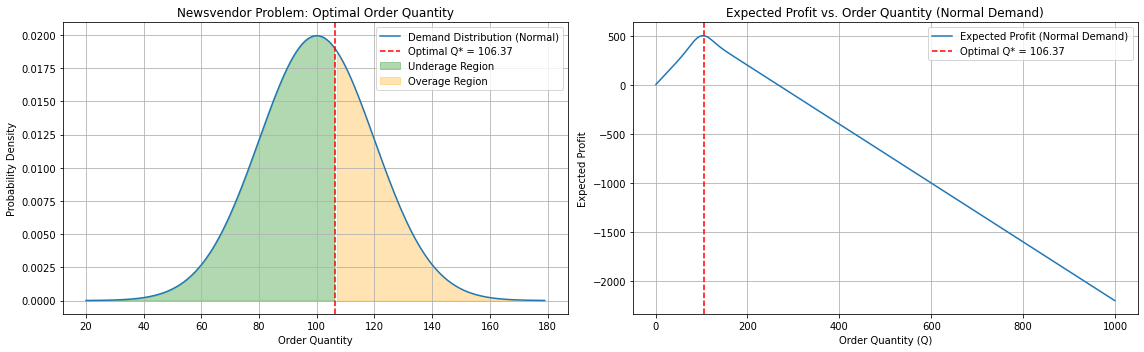

In [24]:
import scipy.stats as stats

# Parameters for the newsvendor problem
mean_demand = 100    # average demand
std_demand = 20      # standard deviation of demand
cost_per_unit = 5    # cost to purchase one unit
price_per_unit = 10  # selling price per unit
salvage_value = 2    # salvage value per unit (if any)

# Critical ratio calculation
critical_ratio = (price_per_unit - cost_per_unit) / (price_per_unit - salvage_value) # <------------------ cirtical ratio yielding critical quantile for optimal order quantity

# Optimal order quantity (Q*)
optimal_order_quantity = stats.norm.ppf(critical_ratio, loc=mean_demand, scale=std_demand)

print(f"Critical ratio: {critical_ratio:.2f}")
print(f"Optimal order quantity: {optimal_order_quantity:.2f}")

import matplotlib.pyplot as plt


### Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot the normal demand distribution and mark the optimal order quantity
x = np.arange(mean_demand - 4*std_demand, mean_demand + 4*std_demand, 1)
pdf = stats.norm.pdf(x, loc=mean_demand, scale=std_demand)


# Left subplot: Demand distribution with optimal order quantity
axes[0].plot(x, pdf, label='Demand Distribution (Normal)')
axes[0].axvline(optimal_order_quantity, color='red', linestyle='--', label=f'Optimal Q* = {optimal_order_quantity:.2f}')
axes[0].fill_between(x, 0, pdf, where=(x <= optimal_order_quantity), color='green', alpha=0.3, label='Underage Region')
axes[0].fill_between(x, 0, pdf, where=(x > optimal_order_quantity), color='orange', alpha=0.3, label='Overage Region')
axes[0].set_xlabel('Order Quantity')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Newsvendor Problem: Optimal Order Quantity')
axes[0].legend()
axes[0].grid(True)


# Plot expected profit as a function of order quantity
expected_profit_normal = []
for Q in Q_values:
    underage = stats.norm.cdf(Q, loc=mean_demand, scale=std_demand)
    expected_sales = mean_demand * underage + Q * (1 - underage)
    expected_leftover = Q - expected_sales
    profit = (expected_sales * price_per_unit) + (expected_leftover * salvage_value) - (Q * cost_per_unit)
    expected_profit_normal.append(profit)


# Right subplot: Expected profit vs. order quantity
axes[1].plot(Q_values, expected_profit_normal, label='Expected Profit (Normal Demand)')
axes[1].axvline(optimal_order_quantity, color='red', linestyle='--', label=f'Optimal Q* = {optimal_order_quantity:.2f}')
axes[1].set_xlabel('Order Quantity (Q)')
axes[1].set_ylabel('Expected Profit')
axes[1].set_title('Expected Profit vs. Order Quantity (Normal Demand)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Extend The problem to take into account "product freshness"

To Expand the problem with a product that can be sold for a variable time (unlike Newspapers which can be sold for fixed periods of time), we need to introduce time as a random variable.
We do using a Exponenetial Distribution, giving a probability distribution of with which probability, how much fresh time can be expected. This is done assuming that all fruits stay fresh for the exact same time and thus the distribution shows the probability of all fruits still being fresh in a given week. This is somewhat unrealistic but done for simplicity. An expansion of the problem could be to use the multivariate distribution of time & number of fresh fruits. 

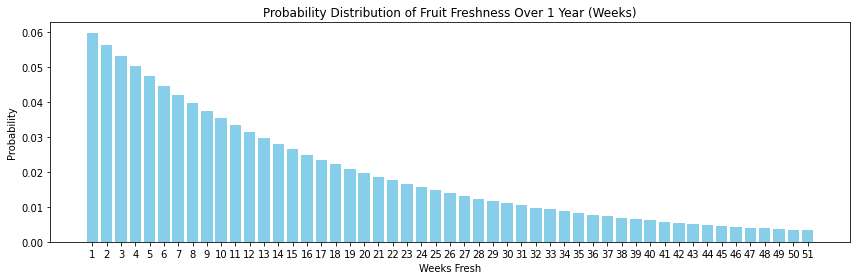

Expected weeks fresh (discrete): 14.90


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Average number of weeks a fruit stays fresh

mean_days_fresh = 120

mean_weeks_fresh = mean_days_fresh / 7

# Create a probability distribution for freshness over the next x weeks
weeks = np.arange(1, 52)  # up to 1 year (52 weeks)
freshness_prob_weeks = np.exp(- (weeks - 1) / mean_weeks_fresh) - np.exp(- weeks / mean_weeks_fresh)

# Normalize to ensure probabilities sum to 1 (optional, for a finite window)
freshness_prob_weeks /= freshness_prob_weeks.sum()

plt.figure(figsize=(12, 4))
plt.bar(weeks, freshness_prob_weeks, color='skyblue')
plt.xlabel('Weeks Fresh')
plt.ylabel('Probability')
plt.title('Probability Distribution of Fruit Freshness Over 1 Year (Weeks)')
plt.xticks(weeks)
plt.tight_layout()
plt.show()

# Calculate the expected number of weeks a fruit stays fresh using the discrete distribution
expected_weeks_fresh = np.sum(weeks * freshness_prob_weeks)
print(f"Expected weeks fresh (discrete): {expected_weeks_fresh:.2f}")


In addition to that, we also have to add the Time Dimension to the Demand Variable, as different time spans of freshness will change how much time the product can be sold, in turn increasing the demand compared to shorter periods of time. We model Demand using a Poisson Distribution with constant rate parameter that grow linealy over time.

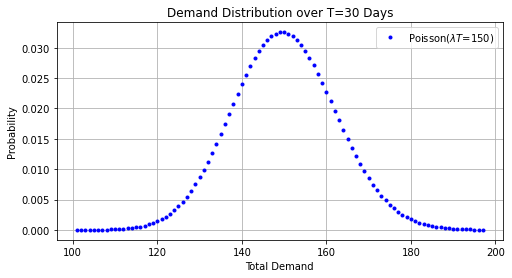

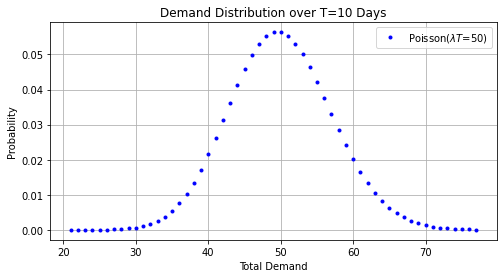

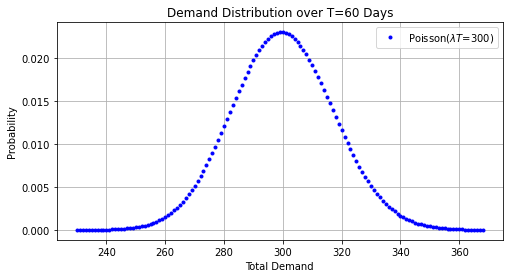

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def plot_demand_distribution(lambda_daily, T):
    
    lambda_total = lambda_daily * T # <---------------------------- Rate of demand over T days

    lower = max(0, int(lambda_total - 4 * np.sqrt(lambda_total)))
    upper = int(lambda_total + 4 * np.sqrt(lambda_total))
    x_range = np.arange(lower, upper)

    # Compute PMF
    pmf = poisson.pmf(x_range, mu=lambda_total)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x_range, pmf, 'bo', ms=3, label=f'Poisson($\\lambda T$={lambda_total})')
    plt.title(f"Demand Distribution over T={T} Days")
    plt.xlabel("Total Demand")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_demand_distribution(lambda_daily=5, T=30)
plot_demand_distribution(lambda_daily=5, T=10)
plot_demand_distribution(lambda_daily=5, T=60)


We then use a scenario based/numeric approach to find the optimal order quantity across all possible time spans provided by the freshness distribution and calculate the expected profit:
The goal is to find the optimal order quantity Q that maximizes expected profit, given that weekly demand is random and fruits go bad after a certain period.

First, the parameters are set:
- lambda_daily: average daily demand
- Q_values: array of possible order quantities (from 1 to 999)
- expected_profits: list to store the expected profit for each Q

For each possible order quantity Q, the expected profit is calculated:
1. For each week (1 to 51), the probability that the goods remain fresh for that long is determined (freshness_prob_weeks).
2. For each week, the demand distribution is discretized as shown above
3. The number of units that can be sold (sales = min(Q, demand)) and the number of leftovers (leftover = max(Q - demand, 0)) are calculated.
4. The profit in this scenario is calculated from sales revenue, salvage value of leftover goods, and purchase costs.
5. The profit is weighted by the probability that the goods remain fresh for exactly that long and added to the total expected profit for Q.

At the end, the order quantity Q with the highest expected profit (best_Q) is selected


__Comments__ 

I am not 100% sure but taking into account the full demand distribution step instead of just using the Expectation might be unecessary as long as freshness and demand are indipendent 

Percent finished: 100.0989989989999570.6006006006006006
Optimal order quantity (scenario-based): 555
Maximum expected profit: 1226.94


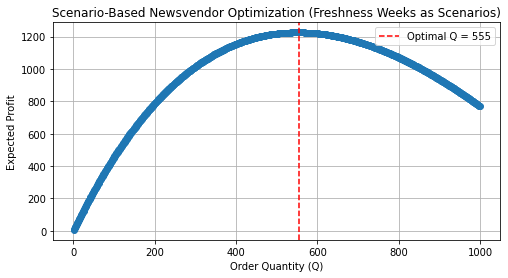

In [ ]:

std_demand = 20      # standard deviation of demand
cost_per_unit = 5    # cost to purchase one unit
price_per_unit = 10  # selling price per unit
salvage_value = 2    # salvage value per unit (if any)


lambda_daily=5
Q_values = np.arange(1, 1000, 1) # <---------------------------- Possible order quantities
expected_profits = []


# Go over all possible order quantities Q
for Q in Q_values:
    print("Percent finished:",Q/len(Q_values)*100, end='\r')  # Progress indicator
    profit = 0
    for week, prob in zip(weeks, freshness_prob_weeks):

        # get demand distribution for this week (using 99.5% confidence interval)
        lambda_total = lambda_daily * 7 * week
        lower = int(poisson.ppf(0.005, mu=lambda_total))
        upper = int(poisson.ppf(0.995, mu=lambda_total))
        demand_range = np.arange(lower, upper + 1)  
        demand_probs = poisson.pmf(demand_range, mu=lambda_total)

        # Calculate expected demand for this week
        d = np.sum(demand_range * demand_probs)

        # Calculate profit for this order quantity Q and week
        sales = min(Q, d)
        leftover = max(Q - d, 0)
        scenario_profit = (sales * price_per_unit) + (leftover * salvage_value) - (Q * cost_per_unit)
        profit += prob * scenario_profit 

        # # Alternative approach: calculate profit for each possible demand
        # # For each possible demand, calculate profit and weight by probability
        # for d, demand_prob in zip(demand_range, demand_probs):
        #     sales = min(Q, d)
        #     leftover = max(Q - d, 0)
        #     scenario_profit = (sales * price_per_unit) + (leftover * salvage_value) - (Q * cost_per_unit)
        #     profit += prob * demand_prob * scenario_profit 

    expected_profits.append(profit)

# Find the Q that maximizes expected profit
best_Q = Q_values[np.argmax(expected_profits)]
max_profit = np.max(expected_profits)

print(f"\nOptimal order quantity (scenario-based): {best_Q}")
print(f"Maximum expected profit: {max_profit:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(Q_values, expected_profits, marker='o')
plt.axvline(best_Q, color='red', linestyle='--', label=f'Optimal Q = {best_Q}')
plt.xlabel('Order Quantity (Q)')
plt.ylabel('Expected Profit')
plt.title('Scenario-Based Newsvendor Optimization (Freshness Weeks as Scenarios)')
plt.legend()
plt.grid(True)
plt.show()

## Comments

With this optimization framework set up, the Data Science Challange now consist out of estimating the probability distributions for freshness {1,0} over time. Here, the previous simplifications like being indipendent of the current time (e.g indipendent of months of the year) to be discarded. Some initial concepts on how to estimate the distributions are:

__Freshness Distribution__ 
- Use Fruit timeseries data taking into account storage conditions to model Survival probability -> Survival Analysis (Dont know much about this but I am sure there are smart ways to solve that problem, a bit of googling yielded some promising model types, taking into account multipele parameters and seasonality, etc.)

__Demand Distribution__ 
- Use classical Demand prediction models taking into account distribution (like Assuming Normal distribution for ARIMA predictions, assuming criterions are fulfilled -> stationarity, etc) and aggregate over time to get total demand distribution for specific time frame


